In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sentencepiece as spm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [ ]:
!pip install kaggle
!kaggle datasets download -d rmisra/news-category-dataset
!unzip news-category-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-category-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
news-category-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  news-category-dataset.zip
  inflating: News_Category_Dataset_v3.json  


In [17]:
# https://www.kaggle.com/datasets/rmisra/news-category-dataset/data

directory = "./News_Category_Dataset_v3.json"
data = pd.read_json(directory, lines=True)
data = data.drop('link', axis=1)
data.head()

,headline,category,short_description,authors,date
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


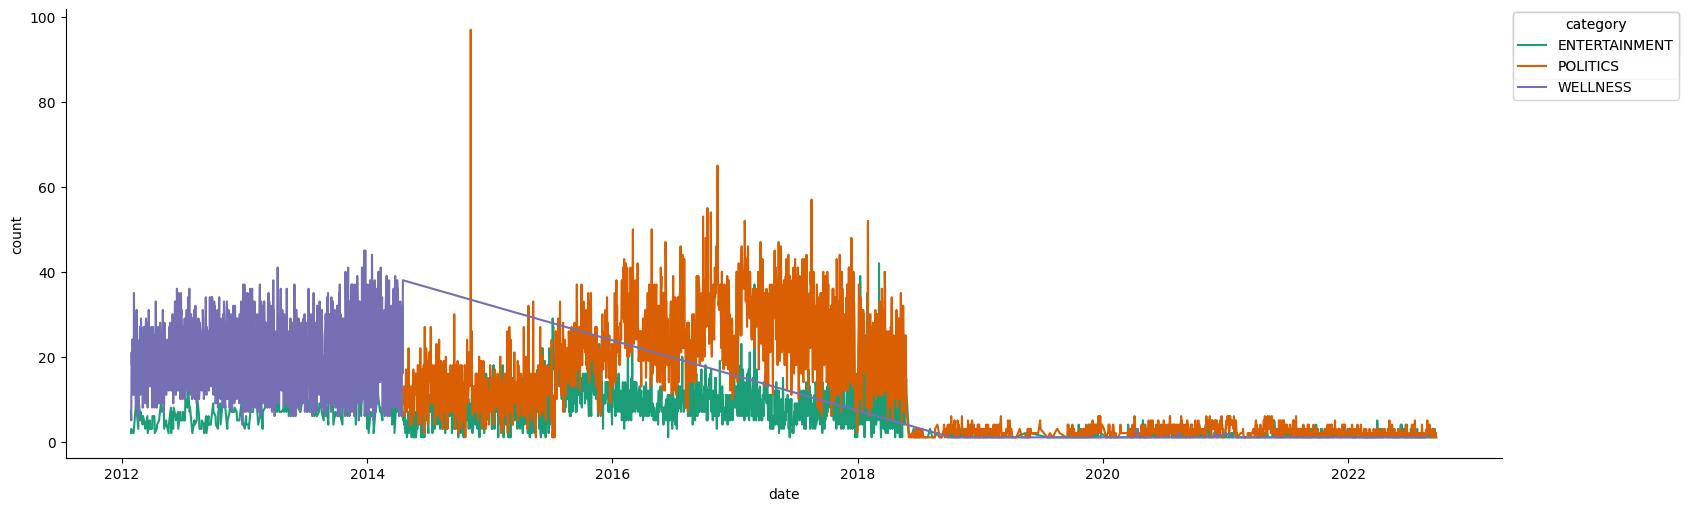

In [ ]:
number_of_categories_to_plot = 3

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')
plot_categories = data.category.value_counts()[:number_of_categories_to_plot].index.tolist()
df_sorted = data[data.category.isin(plot_categories)]
df_sorted = df_sorted.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('category')):
  _plot_series(series, series_name, i)
  fig.legend(title='category', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count')

In [ ]:
data.loc[data['category'].isin(['WEIRD NEWS'])]

,headline,category,short_description,authors,date
29,'French Spider-Man' Celebrates 60th Birthday W...,WEIRD NEWS,"Alain Robert, known as the ""French Spider-Man,...",Ben Blanchet,2022-09-18
38,German Customs Officials Follow Trail Of Slime...,WEIRD NEWS,“Never in the history of the Duesseldorf custo...,,2022-09-16
154,A Fisherman Thought He Caught A Rock. He Snagg...,WEIRD NEWS,The Nebraska man said he initially believed th...,Ben Blanchet,2022-08-27
159,FINISH HIM: Fighting Kangaroo Pulls Wild Move ...,WEIRD NEWS,Two mad marsupials went at it in a Canberra na...,Ed Mazza,2022-08-26
239,Feathers Fly As Wild Turkey Dodges Cops In Sla...,WEIRD NEWS,One officer used a net in an attempt to nab th...,Ben Blanchet,2022-08-11
...,...,...,...,...,...
133464,10 Surprising History Facts That Will Warp You...,WEIRD NEWS,,,2014-04-20
133465,LEFT TO DIE,WEIRD NEWS,,,2014-04-20
133473,Gulag-Themed Holidays Are All the Rage in Sunn...,WEIRD NEWS,The Siberian Times reports that the latest tr...,"Roadtrippers, ContributorTravel local.",2014-04-20
133505,This Cruise Ship From Hell Will Make You Wish ...,WEIRD NEWS,The Crown Princess's seven-day path of destruc...,"Roadtrippers, ContributorTravel local.",2014-04-20


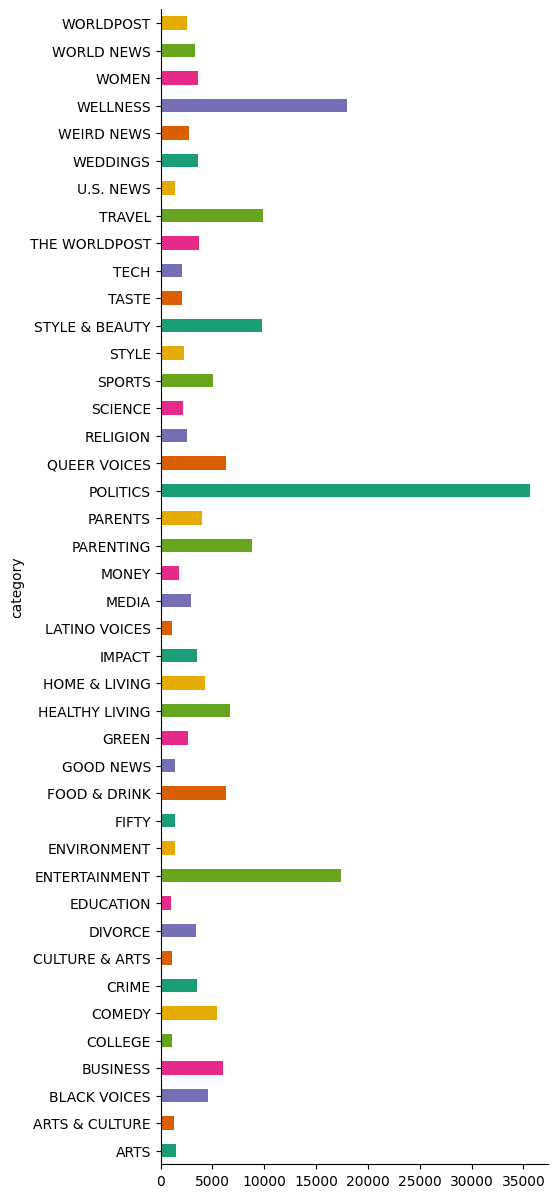

In [ ]:
plt.figure(figsize=(5, 15))
data.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [18]:
def encode(
    df: pd.DataFrame,
    bos_token: int,
    eos_token: int,
    mean: float = None,
    std:float = None
    ):
  """ Tokenize dataframe in the form

      | headline |	category |	short_description |	authors |	date |
            ||          ||              ||             ||       ||
      sentencepiece  index-based   sentencepiece  index-based  Normalized

  Args:
      df: The dataframe to Tokenize.
      mean: Mean for normalization of date.
      std: Standard deviation for normalization of date.

  Returns:
      The tokenized dataframe.
  """

  categories         = df.category.unique().tolist()
  category_tokens_ix = dict(enumerate(categories))
  category_tokens_xi = {x:i for i, x in category_tokens_ix.items()}

  authors           = df.authors.unique().tolist()
  authors_tokens_ix = dict(enumerate(authors))
  authors_tokens_xi = {x:i for i, x in authors_tokens_ix.items()}

  print("Total number of categories:", len(category_tokens_ix))
  print("Total number of Authors:",    len(authors_tokens_ix))

  df['date']    = (df['date'] - df['date'].min()).dt.total_seconds()

  mean = mean if mean else df['date'].mean()
  std  = std if std else df['date'].std()

  print('Using mean as {} for date'.format(mean))
  print('Using std as {} for date'.format(std))

  df['date']              = (df['date'] - mean)/std
  df['category']          = df['category'].map(category_tokens_xi)
  df['authors']           = df['authors'].map(authors_tokens_xi)
  df['headline']          = df['headline'].map(lambda x: [bos_token] + sp.encode_as_ids(x) + [eos_token])
  df['short_description'] = df['short_description'].map(lambda x: [bos_token] + sp.encode_as_ids(x) + [eos_token])

  return df, category_tokens_ix, authors_tokens_ix, mean, std, (len(category_tokens_ix),
                                                                len(authors_tokens_ix))

In [19]:
def pad_dataset(df: pd.DataFrame, PAD_TOKEN: int):
  """Pads the headline and short_description columns of the dataframe with the given pad token.

  Args:
      df: The dataframe to pad.
      pad_token: The token to use for padding.

  Returns:
      The padded dataframe.
  """
  MAX_HEADLINE_LENGHT       = df['headline'].str.len().max()
  MAX_SHORT_DESCRIPTION_LEN = df['short_description'].str.len().max()

  print("Maxlen for headline:", MAX_HEADLINE_LENGHT)
  print("Maxlen for short_description:", MAX_SHORT_DESCRIPTION_LEN)

  df['headline'] = df['headline'].map(lambda x: x + [PAD_TOKEN] * (MAX_HEADLINE_LENGHT - len(x)))
  df['short_description'] = df['short_description'].map(lambda x: x + [PAD_TOKEN] * (MAX_SHORT_DESCRIPTION_LEN - len(x)))

  return df, MAX_HEADLINE_LENGHT, MAX_SHORT_DESCRIPTION_LEN


In [48]:
def block_dataset(df: pd.DataFrame,
                  blocksize: int,
                  maxlen: int,
                  pad_token: int
                  ):

  context = torch.ones(len(df), maxlen, blocksize, dtype=torch.int32) * pad_token
  target = torch.ones(len(df), maxlen-1, dtype=torch.int32) * pad_token

  for i, row in enumerate(df['short_description']):
    for j in range(maxlen-1):
      context[i, j+1] = torch.concat([context[i, j, 1:], torch.tensor([row[j]])])
      target[i, j] = row[j+1]

  context = context[:, 1:].reshape(-1, blocksize)
  target = target.reshape(-1)

  df = df.loc[df.index.repeat([maxlen-1] * len(df))].reset_index(drop=True)
  df['context'] = context.tolist()
  df['target'] = target.tolist()

  return df


In [ ]:
!curl -o m.vocab https://raw.githubusercontent.com/messi10tom/Fake-news-Generator/main/m.vocab
!curl -o m.model https://raw.githubusercontent.com/messi10tom/Fake-news-Generator/main/m.model

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 88432  100 88432    0     0   667k      0 --:--:-- --:--:-- --:--:--  669k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  313k  100  313k    0     0  1914k      0 --:--:-- --:--:-- --:--:-- 1926k


In [26]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

# dataset, token_category, token_author, mean, std, vocabsizes = encode(data.copy(),
#                                                                         sp.bos_id(),
#                                                                        sp.eos_id())
# dataset, maxlen_H, maxlen_S = pad_dataset(dataset, sp.unk_id())

Total number of categories: 42
Total number of Authors: 29169
Using mean as 102645854.34430885 for date
Using std as 65527224.61900345 for date
Maxlen for headline: 187
Maxlen for short_description: 419


In [50]:
class FN_Dataset(Dataset):
    """  Fake News dataset """
    def __init__(self,
                 df: pd.DataFrame,
                 bos_token: int,
                 eos_token: int,
                 pad_token: int,
                 blocksize: int,
                 mean: float = None,
                 std:float = None
                 ):
      """

      Args:
        df              : Dataframe containing the data.
        bos_token       : Beginning of sentence token.
        eos_token       : End of sentence token.
        pad_token       : Padding token.
        mean(Optional)  : Mean for normalization of date.
        std(Optional)   : Standard deviation for normalization of date.

      """

      super().__init__()

      self.df, self.Category_decoder, self.Author_decoder, self.mean, self.std, self.vocabsizes = encode(df, bos_token, eos_token, mean, std)
      self.df, self.maxlen_H, self.maxlen_S = pad_dataset(self.df, pad_token)
      self.df = block_dataset(self.df, blocksize, self.maxlen_S, pad_token)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      sample = self.df.iloc[idx]

      return {
          'headline': torch.tensor(sample['headline']),
          'context': torch.tensor(sample['context']).to(torch.float32),
          'target': torch.tensor(sample['target']),
          'date': torch.tensor([sample['date']]),
          'category': torch.tensor(sample['category']),
          'authors': torch.tensor(sample['authors'])
      }

In [51]:
class FN_Generator(nn.Module):
    """ Generate short_description """
    def __init__(self,
                 units: int,
                 output_dim: int,
                 embed_dim: int,
                 headline_vocabsize: int,
                 inputsize_H: int,
                 inputsize_A: int,
                 cat_vocabsize: int,
                 auth_vocabsize: int
                 ) -> None:

        """
        Args:
          units               : Number of units in the hidden layer.
          output_dim          : Dimension of the output.
          embed_dim           : Dimension of the embedding.
          headline_vocabsize  : Vocabulary size of the headline.
          inputsize_H         : Input size of the headline.
          cat_vocabsize       : Vocabulary size of the category.
          auth_vocabsize      : Vocabulary size of the authors.

        """
        super(FN_Generator, self).__init__()

        self.embed_headline    = nn.Embedding(headline_vocabsize, embed_dim)
        self.embed_cat         = nn.Embedding(cat_vocabsize, embed_dim)
        self.embed_auth        = nn.Embedding(auth_vocabsize, embed_dim)
        self.embed_context     = nn.Embedding(headline_vocabsize, embed_dim)

        self.flatten = nn.Flatten()

        self.Wd = nn.Linear(1, embed_dim)
        self.Wh = nn.Linear(inputsize_H * embed_dim, units)
        self.Wc = nn.Linear(embed_dim, units)
        self.Wa = nn.Linear(embed_dim, units)
        self.Wo = nn.Linear(inputsize_A * embed_dim, units)

        self.output = nn.Linear(units, output_dim)

    def forward(self, dataset):
        EMB_h    = self.embed_headline(dataset['headline'])
        EMB_c    = self.embed_cat(dataset['category'])
        EMB_a    = self.embed_auth(dataset['authors'])
        EMB_o    = self.embed_context(dataset['context'])

        EMB_h = self.flatten(EMB_h)

        lin = self.Wh(EMB_h) + self.Wc(EMB_c) + self.Wa(EMB_a) + self.Wd(dataset['date']) + self.Wo(EMB_o)
        lin = torch.relu(lin)

        return torch.relu(self.output(lin))

In [ ]:
dataset = FN_Dataset(df=data.copy()[:100],
                     bos_token=sp.bos_id(),
                     eos_token=sp.eos_id(),
                     pad_token=sp.unk_id(),
                     blocksize=sp.vocab_size())
dataloader = DataLoader(dataset, batch_size=32,
                        shuffle=True, num_workers=2)
generator = FN_Generator(16, dataset.maxlen_S, 8, sp.vocab_size(), dataset.maxlen_H, *dataset.vocabsizes)

Total number of categories: 42
Total number of Authors: 29169
Using mean as 5000 for date
Using std as 65527224.61900345 for date
Maxlen for headline: 187
Maxlen for short_description: 419


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(generator.parameters(), lr=0.005)

In [ ]:
for epoch in range(5):
    for i, ds in enumerate(dataloader):
        optimizer.zero_grad()
        output = generator(ds)
        loss = criterion(output, ds['short_description'])
        loss.backward()
        optimizer.step()
    print('Epoch',epoch,' Loss -->',loss.item())

Epoch 0  Loss --> 118176.5390625
Epoch 1  Loss --> 103136.2421875
Epoch 2  Loss --> 109373.5859375
Epoch 3  Loss --> 88885.46875
Epoch 4  Loss --> 106172.078125
